In [1]:
# Import the classes
from thesisv3.classism import MusicFileManager, MusicSegmentAnalyzer, MusicVisualizer, GraphBuilder, GraphBatcher

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\.School\Thesisv3\.venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [6]:
file_manager = MusicFileManager()
file_manager.display_selector()

In [9]:
analyzer = MusicSegmentAnalyzer()
analyzer.load_score(file_manager.selected_file)
analyzer.analyze_segments()
analyzer.preprocess_segments()
analyzer.nmat

onset_beats  onset_beats_in_measure  duration_beats  midi_pitch  \
0           0.00                    0.00            0.50        66.0   
1           0.50                    0.00            1.50        66.0   
2           2.00                    1.50            1.00        66.0   
3           3.00                    2.50            0.25        65.0   
4           3.25                    2.75            0.25        63.0   
..           ...                     ...             ...         ...   
476       150.50                    0.00            1.00        54.0   
477       151.50                    1.00            2.00         0.0   
478       153.50                    0.00            3.00        63.0   
479       156.50                    0.00            3.00        63.0   
480       156.50                    0.00            3.00        55.0   

     pitch_class  octave  beat_strength ir_symbol  pattern_index  
0            6.0     4.0          0.250         D            0.0  
1            6.0     4.0          1.000         D            0.0  
2            6.0     4.0          0.500         D            0.0  
3            5.0     4.0          0.250        VR            1.0  
4            3.0     4.0          0.125        VR            1.0  
..           ...     ...            ...       ...            ...  
476          6.0     3.0          1.000         M          169.0  
477          0.0     0.0          0.250      rest          170.0  
478          3.0     4.0          1.000        VR          171.0  
479          3.0     4.0          1.000        VR          171.0  
480          7.0     3.0          1.000        VR          171.0  

[481 rows x 9 columns]

# Batch

In [2]:
batcher = GraphBatcher(k=6)

Loaded previous progress: 39 files already processed


In [3]:
batcher.batch()

Skipping already processed file: Bach | Cello Suite No. 1 in G Major
Skipping already processed file: Bach | Cello Suite No. 2 in D Minor
Skipping already processed file: Bach | Cello Suite No. 3 in C Major
Skipping already processed file: Bach | Cello Suite No. 4 in E-flat Major
Skipping already processed file: Bach | Cello Suite No. 5 in C Minor
Skipping already processed file: Bach | Cello Suite No. 6 in D Major
Skipping already processed file: Chopin | Étude Op. 10 No. 1 'Waterfall'
Skipping already processed file: Chopin | Étude Op. 10 No. 2 'Chromatic'
Skipping already processed file: Chopin | Étude Op. 10 No. 4 'Torrent'
Skipping already processed file: Chopin | Étude Op. 10 No. 5 'Black Keys'
Skipping already processed file: Chopin | Étude Op. 10 No. 6 'Lament'
Skipping already processed file: Chopin | Étude Op. 10 No. 7 'Toccata'
Skipping already processed file: Chopin | Étude Op. 10 No. 8 'Sunshine'
Skipping already processed file: Chopin | Étude Op. 10 No. 9
Skipping already

# GRAPH

In [4]:
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
from scipy.sparse import csgraph
from scipy.linalg import eigh
from grakel import Graph
from grakel.kernels import WeisfeilerLehman
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def spectral_partition(distance_matrix):
    # Convert distance to similarity
    sigma = np.mean(distance_matrix[np.nonzero(distance_matrix)])
    similarity_matrix = np.exp(-distance_matrix ** 2 / (2. * sigma ** 2))
    np.fill_diagonal(similarity_matrix, 0)
    # Compute Laplacian
    laplacian = csgraph.laplacian(similarity_matrix, normed=True)
    # Eigen decomposition
    eigenvalues, eigenvectors = eigh(laplacian)
    # Fiedler vector
    fiedler_vector = eigenvectors[:, 1]
    # Partition
    partition = fiedler_vector > 0
    group_1 = np.where(partition)[0]
    group_2 = np.where(~partition)[0]
    return group_1, group_2

def kernighan_lin_partition(distance_matrix, seed=None):
    """
    Partition a set of nodes using the Kernighan-Lin algorithm based on a distance matrix.
    Returns two groups of node indices similar to the spectral_partition function.

    Parameters:
    -----------
    distance_matrix : np.ndarray
        Matrix of distances between nodes
    seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    tuple: (group_1, group_2)
        Two arrays of node indices representing the partition
    """
    import numpy as np
    import networkx as nx

    # Create a graph from the distance matrix
    n = distance_matrix.shape[0]
    graph = nx.Graph()

    # Add all nodes
    for i in range(n):
        graph.add_node(i)

    # Add edges with weights based on inverse distance
    for i in range(n):
        for j in range(i+1, n):
            if distance_matrix[i, j] > 0:  # Only add edges for non-zero distances
                # Convert distance to weight (inverse of distance)
                weight = 1 / (distance_matrix[i, j] + 1e-5)  # Add small constant to avoid division by zero
                graph.add_edge(i, j, weight=weight)

    # Set random seed
    rng = np.random.default_rng(seed)

    # Use Kernighan-Lin bisection
    partition = nx.algorithms.community.kernighan_lin_bisection(graph, weight="weight", seed=rng)

    # Extract nodes from the partitions
    group_1 = np.array(list(partition[0]))
    group_2 = np.array(list(partition[1]))

    return group_1, group_2

def get_sub_distance_matrix(distance_matrix, group_indices):
    return distance_matrix[np.ix_(group_indices, group_indices)]

def dist_mat_to_graph(k: int, distance_matrix):
  # Compute the k-NN graph
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')
  # Convert the k-NN graph to a NetworkX graph
  G = nx.from_scipy_sparse_array(knn_graph)
  return G

In [5]:
def distance_matrices_to_knn_graphs(k: int, distance_matrices: dict, seed: int, iterations: int):
    """
    Creates KNN graphs from distance matrices and plots them in a grid layout.

    Parameters:
    k (int): Number of nearest neighbors for the KNN graph.
    distance_matrices (dict): Dictionary where keys are composer names and values are distance matrices.
    seed (int): Random seed for the spring layout.
    iterations (int): Number of iterations for the spring layout.
    """
    num_graphs = len(distance_matrices)
    rows_needed = (num_graphs + 1) // 2  # Calculate rows needed for two columns
    fig, axes = plt.subplots(rows_needed, 2, figsize=(12, rows_needed * 5))  # 2 columns, rows as needed

    if num_graphs == 1:
        axes = np.array([[axes]])  # Ensure axes is 2D array for single graph
    elif num_graphs == 2:
        axes = axes.reshape(-1, 2)  # Reshape to ensure 2 columns when exactly two graphs

    axes = axes.flatten()  # Flatten the axes array to iterate easily
    for ax, (composer, distance_matrix) in zip(axes, distance_matrices.items()):
        knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')
        G = nx.from_scipy_sparse_array(knn_graph)

        # Detect if the graph is disjoint
        # if not nx.is_connected(G):
        #     print(f"The KNN graph for {composer} is disjoint. Ensuring connectivity...")
        #
        #     # Calculate the connected components
        #     components = list(nx.connected_components(G))
        #
        #     # Connect the components
        #     for i in range(len(components) - 1):
        #         min_dist = np.inf
        #         closest_pair = None
        #         for node1 in components[i]:
        #             for node2 in components[i + 1]:
        #                 dist = distance_matrix[node1, node2]
        #                 if dist < min_dist:
        #                     min_dist = dist
        #                     closest_pair = (node1, node2)
        #
        #         # Add an edge between the closest pair of nodes from different components
        #         G.add_edge(closest_pair[0], closest_pair[1])


        # Plot the final connected graph
        pos = nx.spring_layout(G, seed=seed, iterations=iterations)
        nx.draw(G, node_size=50, pos=pos, ax=ax)
        ax.set_title(f"{composer} (K={k})")
        ax.axis('off')

        output_dir = "..Output"
        fig_individual, ax_individual = plt.subplots(figsize=(6, 5))
        nx.draw(G, node_size=50, pos=pos, ax=ax_individual)
        ax_individual.set_title(f"{composer} (K={k})")
        ax_individual.axis('off')
        # fig_individual.savefig(f"{composer}_KNN_graph.png") # TODO: UNCOMMENT THIS TO SAVE PNG
        plt.close(fig_individual)

    # Hide any unused axes if there are fewer graphs than subplots
    for ax in axes[num_graphs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
def nx_to_grakel(G):
    edges = list(G.edges())
    labels = {node: idx for idx, node in enumerate(G.nodes())}
    return Graph(edges, node_labels=labels)

# Function to apply WL graph kernel to compare graphs
def compare_graphs(graph_list):
    # Convert all graphs to Grakel format
    grakel_graphs = [nx_to_grakel(g) for g in graph_list]

    # Initialize the Weisfeiler-Lehman kernel
    wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True)

    # Compute the WL kernel similarity matrix
    similarity_matrix = wl_kernel.fit_transform(grakel_graphs)

    return similarity_matrix

In [7]:
def compare_within_and_between_artists(artists_dist_mat, k):
    """
    Compares within-artist and between-artist similarity scores, labeling them accordingly.

    Parameters:
    - artists_dist_mat (dict): A dictionary where keys are artist names and values are distance matrices.
    - k (int): Number of neighbors for k-NN graph.

    Returns:
    - within_artist_df (pd.DataFrame): DataFrame with artist names and their within-artist similarity scores.
    - between_artist_df (pd.DataFrame): DataFrame with pairs of artist names and their between-artist similarity scores.
    """
    within_artist_scores = []
    between_artist_scores = []

    # Convert each artist's segments into graphs
    partitioned_artist_graphs = {}
    full_artist_graphs = {}
    for artist, dist_mat in artists_dist_mat.items():
        if len(dist_mat) < 30:
            print(f"Skipping {artist}: insufficient segments ({len(dist_mat)})")
            continue
        group1, group2 = spectral_partition(dist_mat)

        D_group1 = get_sub_distance_matrix(dist_mat, group1)
        D_group2 = get_sub_distance_matrix(dist_mat, group2)

        # Generate k-NN graphs for each partition
        graph_1 = dist_mat_to_graph(k, D_group1)
        graph_2 = dist_mat_to_graph(k, D_group2)
        full_graph = dist_mat_to_graph(k, dist_mat)

        # Store the graphs for later comparisons
        partitioned_artist_graphs[artist] = (graph_1, graph_2)
        full_artist_graphs[artist] = full_graph

        # Compute WL kernel similarity for within-artist (same artist)
        similarity_within = compare_graphs([graph_1, graph_2])[0, 1]
        within_artist_scores.append({
            'Artist': artist,
            'Within_Similarity': similarity_within
        })


    # Compare between artists
    artist_names = list(partitioned_artist_graphs.keys())
    for i in range(len(artist_names)):
        for j in range(len(artist_names)):
            artist_1, artist_2 = artist_names[i], artist_names[j]
            full_graph1 = full_artist_graphs[artist_1]
            full_graph2 = full_artist_graphs[artist_2]

            # Compute WL kernel similarity between graph_1 of artist1 and graph_1 of artist2
            similarity_between = compare_graphs([full_graph1, full_graph2])[0, 1]
            between_artist_scores.append({
                'Artist_1': artist_1,
                'Artist_2': artist_2,
                'Between_Similarity': similarity_between
            })

    # Convert lists of dictionaries to DataFrames for better labeling and analysis
    within_artist_df = pd.DataFrame(within_artist_scores)
    between_artist_df = pd.DataFrame(between_artist_scores)

    return within_artist_df, between_artist_df

In [30]:
x, y = compare_within_and_between_artists(batcher.distmat_dict, k=6)

Skipping Mozart | Minuet in G Major: insufficient segments (10)
Skipping Satie | Gnossienne No. 1: insufficient segments (27)
Skipping Satie | Gnossienne No. 2: insufficient segments (23)
Skipping Satie | Gnossienne No. 3: insufficient segments (15)
Skipping Satie | Gnossienne No. 4: insufficient segments (18)


In [8]:
pieces = batcher.processed_files
for i, name in enumerate(pieces):
    print(f"{i}: {name}")

0: Bach | Cello Suite No. 1 in G Major
1: Bach | Cello Suite No. 2 in D Minor
2: Bach | Cello Suite No. 3 in C Major
3: Bach | Cello Suite No. 4 in E-flat Major
4: Bach | Cello Suite No. 5 in C Minor
5: Bach | Cello Suite No. 6 in D Major
6: Chopin | Étude Op. 10 No. 1 'Waterfall'
7: Chopin | Étude Op. 10 No. 2 'Chromatic'
8: Chopin | Étude Op. 10 No. 4 'Torrent'
9: Chopin | Étude Op. 10 No. 5 'Black Keys'
10: Chopin | Étude Op. 10 No. 6 'Lament'
11: Chopin | Étude Op. 10 No. 7 'Toccata'
12: Chopin | Étude Op. 10 No. 8 'Sunshine'
13: Chopin | Étude Op. 10 No. 9
14: Chopin | Étude Op. 10 No. 10
15: Chopin | Étude Op. 25 No. 2 'The Bees'
16: Chopin | Étude Op. 25 No. 9 'Butterfly'
17: Chopin | Étude Op. 25 No. 11 'Winter Wind'
18: Chopin | Étude Op. 25 No. 12 'Ocean'
19: Chopin | Waltz Op. 34 No. 1 in A-flat Major
20: Chopin | Waltz Op. 34 No. 2 in A Minor
21: Chopin | Waltz Op. 34 No. 3 in F Major
22: Chopin | Waltz Op. 64 No. 1 'Minute Waltz'
23: Chopin | Waltz Op. 64 No. 2 in C Minor


In [13]:
filename = pieces[38]
# Perform spectral partitioning
group1, group2 = spectral_partition(batcher.distmat_dict[filename])

# Extract sub-distance matrices
D_group1 = get_sub_distance_matrix(batcher.distmat_dict[filename], group1)
D_group2 = get_sub_distance_matrix(batcher.distmat_dict[filename], group2)

In [14]:
dm = {f'{filename}\nSpectral Partition 1\n': D_group1, f'{filename}\nSpectral Partition 2\n': D_group2}

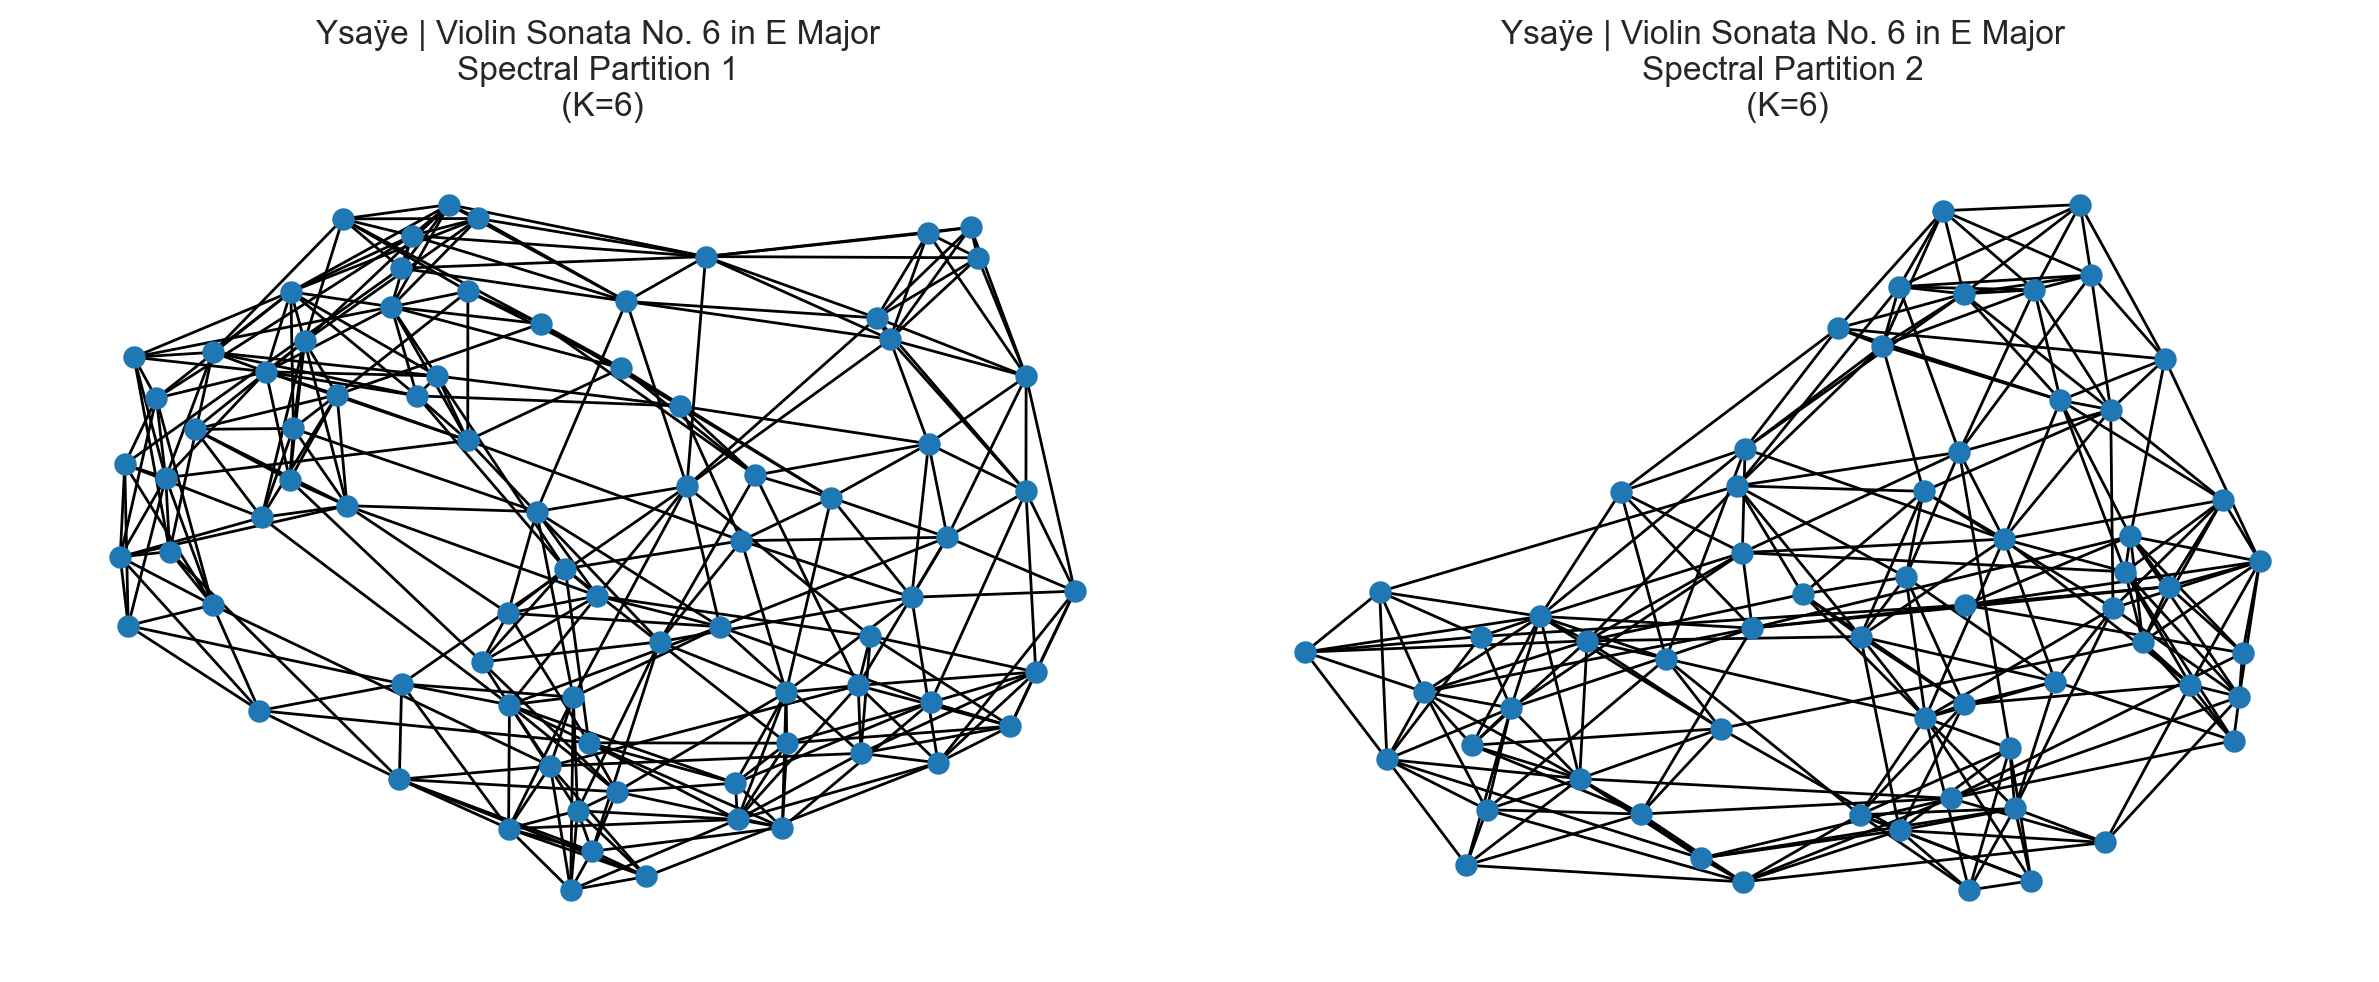

In [15]:
distance_matrices_to_knn_graphs(6, dm, 69, 777)


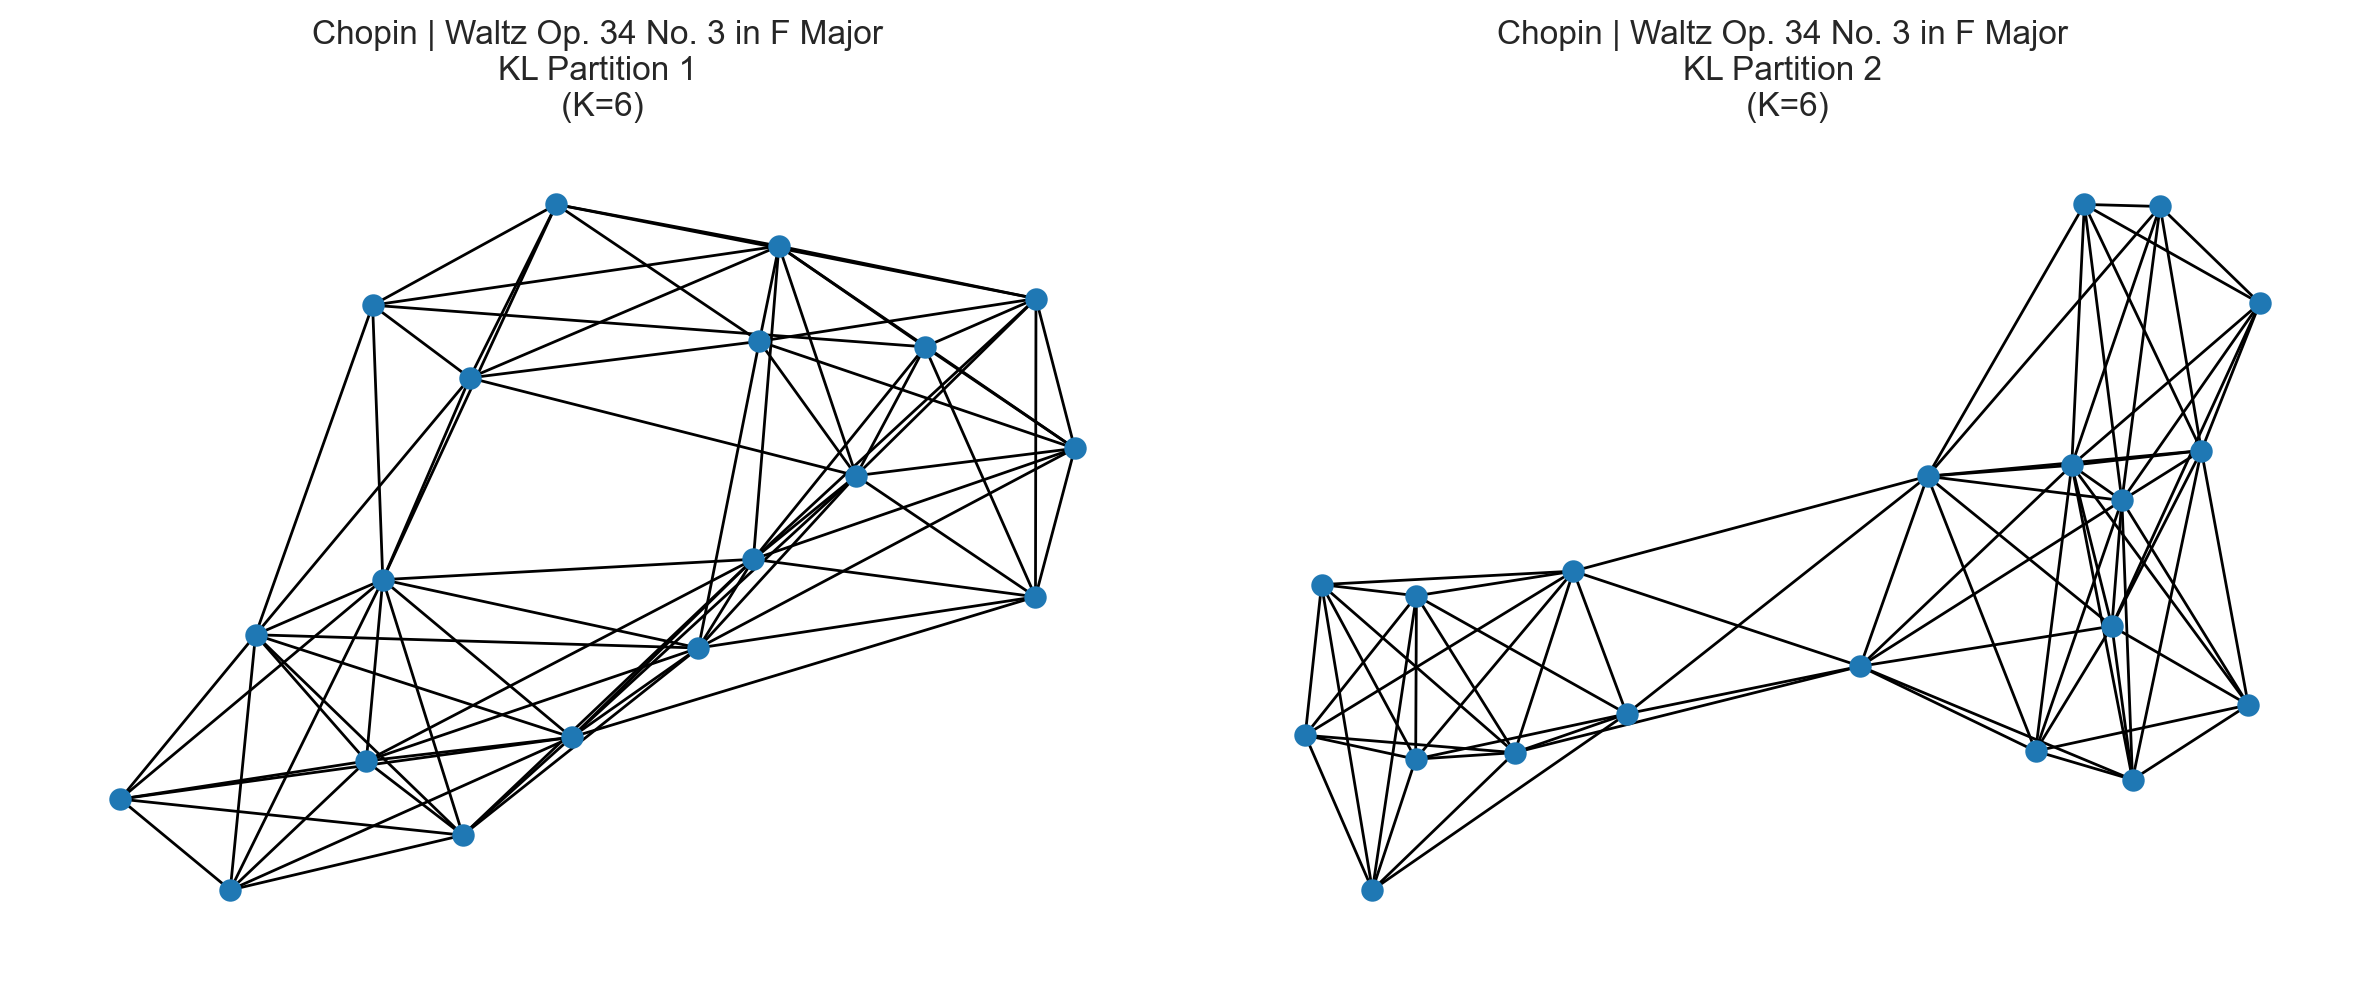

In [80]:
filename = pieces[21]
# Perform spectral partitioning
group1, group2 = kernighan_lin_partition(batcher.distmat_dict[filename])

# Extract sub-distance matrices
D_group1 = get_sub_distance_matrix(batcher.distmat_dict[filename], group1)
D_group2 = get_sub_distance_matrix(batcher.distmat_dict[filename], group2)
dm = {f'{filename}\nKL Partition 1\n': D_group1, f'{filename}\nKL Partition 2\n': D_group2}
distance_matrices_to_knn_graphs(6, dm, 9, 1777)

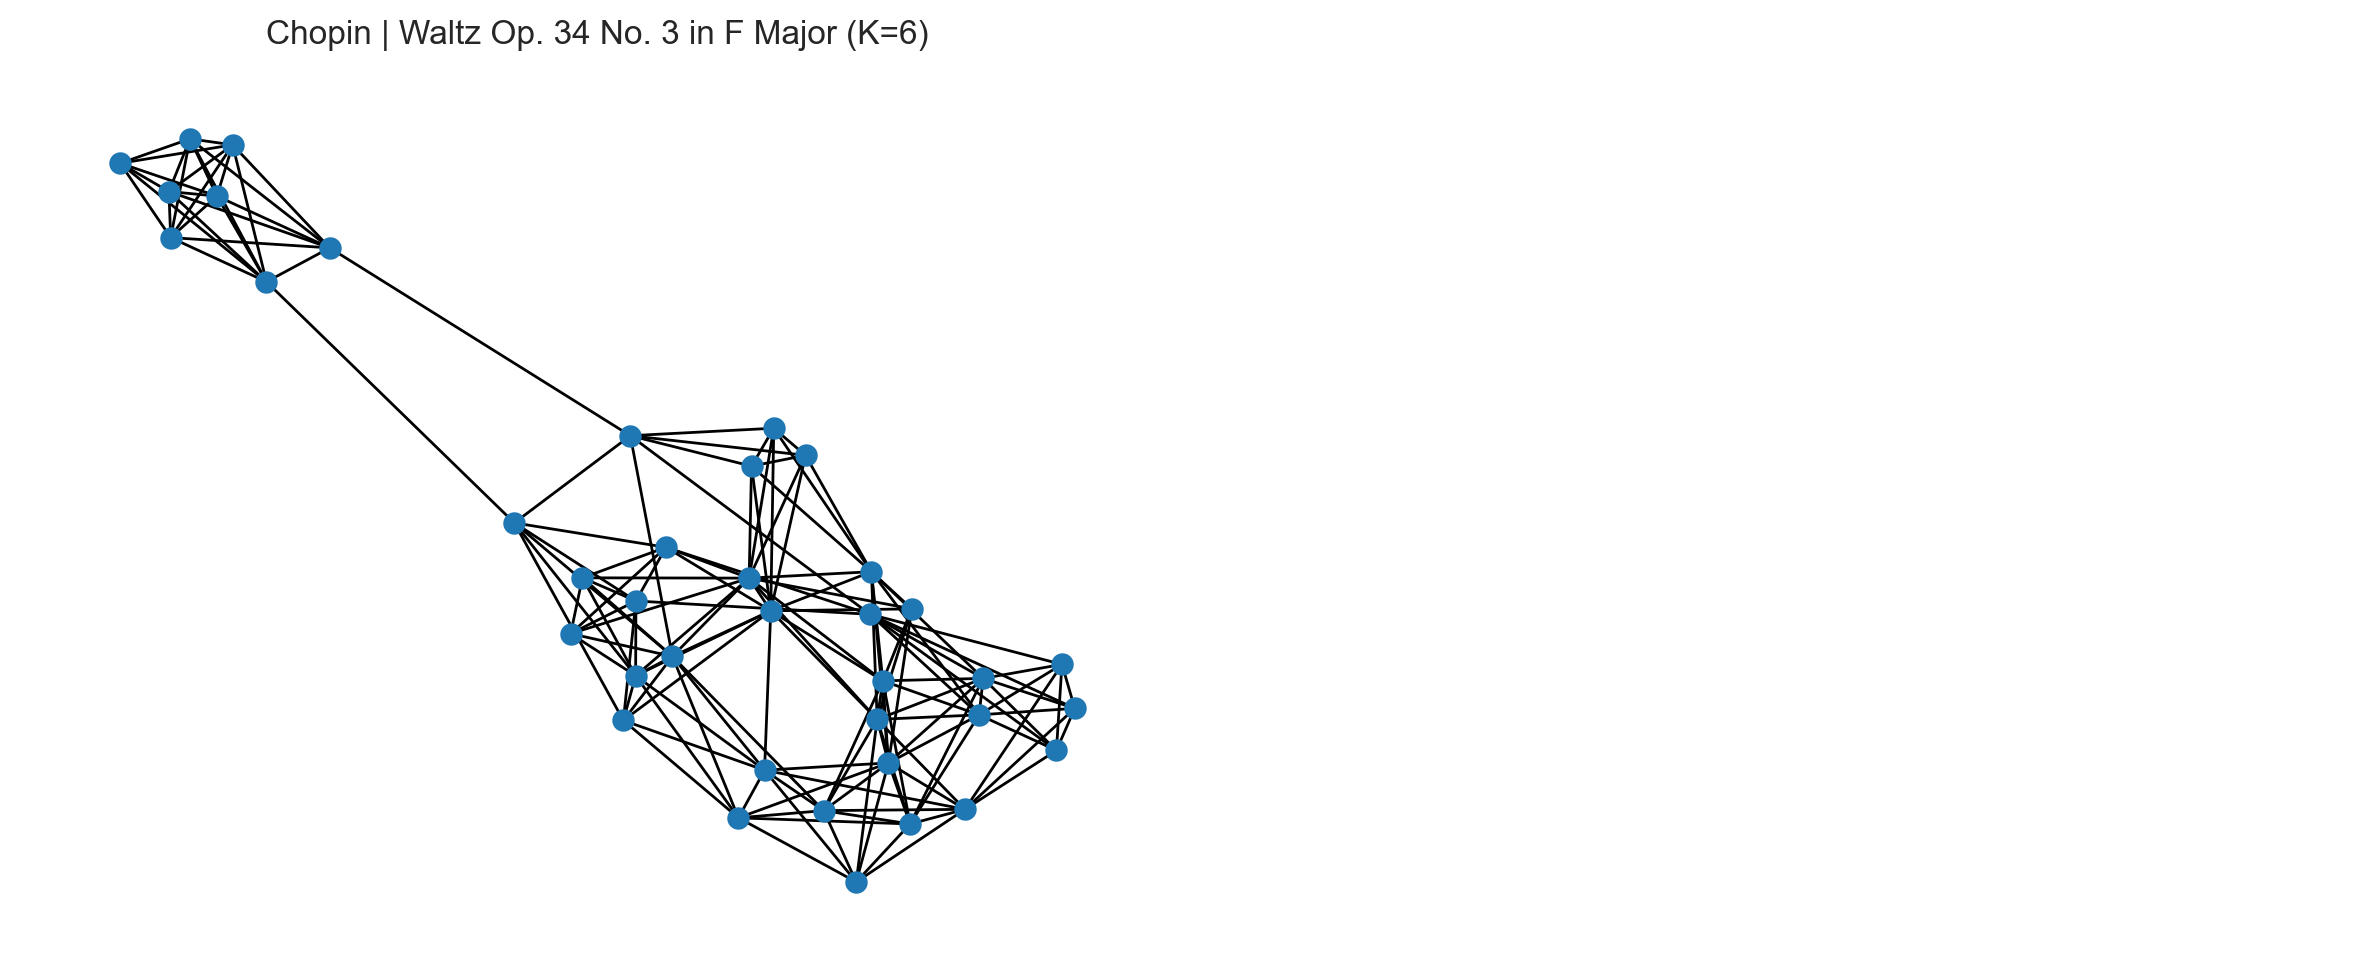

In [81]:
main = {f"{filename}": batcher.distmat_dict[filename]}
distance_matrices_to_knn_graphs(6, main, 9, 1777)


In [40]:
x2 = x.rename(columns={"Artist": "Artist_1", "Within_Similarity": "Between_Similarity"})
x2['Artist_2'] = x2['Artist_1']
x2 = x2[['Artist_1', 'Artist_2', 'Between_Similarity']]
x2.sort_values(by='Artist_1', ascending=True, inplace=True)
x2

Artist_1  \
0                 Bach | Cello Suite No. 1 in G Major   
1                 Bach | Cello Suite No. 2 in D Minor   
2                 Bach | Cello Suite No. 3 in C Major   
3            Bach | Cello Suite No. 4 in E-flat Major   
4                 Bach | Cello Suite No. 5 in C Minor   
5                 Bach | Cello Suite No. 6 in D Major   
19        Chopin | Waltz Op. 34 No. 1 in A-flat Major   
20             Chopin | Waltz Op. 34 No. 2 in A Minor   
21             Chopin | Waltz Op. 34 No. 3 in F Major   
25                   Chopin | Waltz Op. 42 in A Major   
22         Chopin | Waltz Op. 64 No. 1 'Minute Waltz'   
23             Chopin | Waltz Op. 64 No. 2 in C Minor   
24        Chopin | Waltz Op. 64 No. 3 in A-flat Major   
6             Chopin | Étude Op. 10 No. 1 'Waterfall'   
14                       Chopin | Étude Op. 10 No. 10   
7             Chopin | Étude Op. 10 No. 2 'Chromatic'   
8               Chopin | Étude Op. 10 No. 4 'Torrent'   
9            Chopin | Étude Op. 10 No. 5 'Black Keys'   
10               Chopin | Étude Op. 10 No. 6 'Lament'   
11              Chopin | Étude Op. 10 No. 7 'Toccata'   
12             Chopin | Étude Op. 10 No. 8 'Sunshine'   
13                        Chopin | Étude Op. 10 No. 9   
17         Chopin | Étude Op. 25 No. 11 'Winter Wind'   
18               Chopin | Étude Op. 25 No. 12 'Ocean'   
15             Chopin | Étude Op. 25 No. 2 'The Bees'   
16            Chopin | Étude Op. 25 No. 9 'Butterfly'   
26  Mozart | Piano Sonata No. 10 in C Major, K. 33...   
27  Mozart | Piano Sonata No. 11 in A Major, K. 33...   
28             Ysaÿe | Violin Sonata No. 1 in G Minor   
29             Ysaÿe | Violin Sonata No. 2 in A Minor   
30             Ysaÿe | Violin Sonata No. 3 in D Minor   
31             Ysaÿe | Violin Sonata No. 4 in E Minor   
32             Ysaÿe | Violin Sonata No. 5 in G Major   
33             Ysaÿe | Violin Sonata No. 6 in E Major   

                                             Artist_2  Between_Similarity  
0                 Bach | Cello Suite No. 1 in G Major            0.194738  
1                 Bach | Cello Suite No. 2 in D Minor            0.171645  
2                 Bach | Cello Suite No. 3 in C Major            0.183843  
3            Bach | Cello Suite No. 4 in E-flat Major            0.161707  
4                 Bach | Cello Suite No. 5 in C Minor            0.196295  
5                 Bach | Cello Suite No. 6 in D Major            0.167773  
19        Chopin | Waltz Op. 34 No. 1 in A-flat Major            0.160192  
20             Chopin | Waltz Op. 34 No. 2 in A Minor            0.132068  
21             Chopin | Waltz Op. 34 No. 3 in F Major            0.139010  
25                   Chopin | Waltz Op. 42 in A Major            0.131958  
22         Chopin | Waltz Op. 64 No. 1 'Minute Waltz'            0.120386  
23             Chopin | Waltz Op. 64 No. 2 in C Minor            0.222608  
24        Chopin | Waltz Op. 64 No. 3 in A-flat Major            0.175379  
6             Chopin | Étude Op. 10 No. 1 'Waterfall'            0.131641  
14                       Chopin | Étude Op. 10 No. 10            0.156432  
7             Chopin | Étude Op. 10 No. 2 'Chromatic'            0.131405  
8               Chopin | Étude Op. 10 No. 4 'Torrent'            0.136083  
9            Chopin | Étude Op. 10 No. 5 'Black Keys'            0.156556  
10               Chopin | Étude Op. 10 No. 6 'Lament'            0.154887  
11              Chopin | Étude Op. 10 No. 7 'Toccata'            0.157811  
12             Chopin | Étude Op. 10 No. 8 'Sunshine'            0.119433  
13                        Chopin | Étude Op. 10 No. 9            0.134371  
17         Chopin | Étude Op. 25 No. 11 'Winter Wind'            0.170685  
18               Chopin | Étude Op. 25 No. 12 'Ocean'            0.174101  
15             Chopin | Étude Op. 25 No. 2 'The Bees'            0.141639  
16            Chopin | Étude Op. 25 No. 9 'Butterfly'            0.132453

In [41]:
y

Artist_1  \
0        Bach | Cello Suite No. 1 in G Major   
1        Bach | Cello Suite No. 1 in G Major   
2        Bach | Cello Suite No. 1 in G Major   
3        Bach | Cello Suite No. 1 in G Major   
4        Bach | Cello Suite No. 1 in G Major   
...                                      ...   
1151  Ysaÿe | Violin Sonata No. 6 in E Major   
1152  Ysaÿe | Violin Sonata No. 6 in E Major   
1153  Ysaÿe | Violin Sonata No. 6 in E Major   
1154  Ysaÿe | Violin Sonata No. 6 in E Major   
1155  Ysaÿe | Violin Sonata No. 6 in E Major   

                                      Artist_2  Between_Similarity  
0          Bach | Cello Suite No. 1 in G Major            1.000000  
1          Bach | Cello Suite No. 2 in D Minor            0.178700  
2          Bach | Cello Suite No. 3 in C Major            0.146769  
3     Bach | Cello Suite No. 4 in E-flat Major            0.133559  
4          Bach | Cello Suite No. 5 in C Minor            0.149604  
...                                        ...                 ...  
1151    Ysaÿe | Violin Sonata No. 2 in A Minor            0.135448  
1152    Ysaÿe | Violin Sonata No. 3 in D Minor            0.170432  
1153    Ysaÿe | Violin Sonata No. 4 in E Minor            0.134513  
1154    Ysaÿe | Violin Sonata No. 5 in G Major            0.137379  
1155    Ysaÿe | Violin Sonata No. 6 in E Major            1.000000  

[1156 rows x 3 columns]

In [42]:
df_filtered = y[y['Artist_1'] != y['Artist_2']]
df_filtered = pd.concat([df_filtered, x2], ignore_index=True)
df_filtered.sort_values(by=['Artist_1', 'Artist_2'], ascending=True, inplace=True)
df_filtered.reset_index(drop=True, inplace=True)

In [43]:
df_filtered.loc[:, 'Between_Similarity'] = (df_filtered['Between_Similarity'] - df_filtered['Between_Similarity'].min()) / (df_filtered['Between_Similarity'].max() - df_filtered['Between_Similarity'].min())

In [44]:
df_filtered.rename(columns={"Artist_1": "Piece_1", "Artist_2": "Piece_2"}, inplace=True)

In [87]:
from thesisv3.validation.clustering import GraphKMeans

g_kmeans = GraphKMeans(batcher.processed_files, batcher.graphs, k=6)
clustered, labels = g_kmeans.get_labels()
clustered

file  label
0                 Bach | Cello Suite No. 1 in G Major      2
1                 Bach | Cello Suite No. 2 in D Minor      5
2                 Bach | Cello Suite No. 3 in C Major      2
3            Bach | Cello Suite No. 4 in E-flat Major      5
4                 Bach | Cello Suite No. 5 in C Minor      5
5                 Bach | Cello Suite No. 6 in D Major      5
6             Chopin | Étude Op. 10 No. 1 'Waterfall'      5
7             Chopin | Étude Op. 10 No. 2 'Chromatic'      5
8               Chopin | Étude Op. 10 No. 4 'Torrent'      3
9            Chopin | Étude Op. 10 No. 5 'Black Keys'      4
10               Chopin | Étude Op. 10 No. 6 'Lament'      3
11              Chopin | Étude Op. 10 No. 7 'Toccata'      0
12             Chopin | Étude Op. 10 No. 8 'Sunshine'      3
13                        Chopin | Étude Op. 10 No. 9      0
14                       Chopin | Étude Op. 10 No. 10      0
15             Chopin | Étude Op. 25 No. 2 'The Bees'      4
16            Chopin | Étude Op. 25 No. 9 'Butterfly'      3
17         Chopin | Étude Op. 25 No. 11 'Winter Wind'      1
18               Chopin | Étude Op. 25 No. 12 'Ocean'      4
19        Chopin | Waltz Op. 34 No. 1 in A-flat Major      4
20             Chopin | Waltz Op. 34 No. 2 in A Minor      4
21             Chopin | Waltz Op. 34 No. 3 in F Major      4
22         Chopin | Waltz Op. 64 No. 1 'Minute Waltz'      4
23             Chopin | Waltz Op. 64 No. 2 in C Minor      4
24        Chopin | Waltz Op. 64 No. 3 in A-flat Major      3
25                   Chopin | Waltz Op. 42 in A Major      0
26                         Mozart | Minuet in G Major      3
27  Mozart | Piano Sonata No. 10 in C Major, K. 33...      3
28  Mozart | Piano Sonata No. 11 in A Major, K. 33...      3
29                           Satie | Gnossienne No. 1      3
30                           Satie | Gnossienne No. 2      3
31                           Satie | Gnossienne No. 3      3
32                           Satie | Gnossienne No. 4      3
33             Ysaÿe | Violin Sonata No. 1 in G Minor      2
34             Ysaÿe | Violin Sonata No. 2 in A Minor      4
35             Ysaÿe | Violin Sonata No. 3 in D Minor      4
36             Ysaÿe | Violin Sonata No. 4 in E Minor      2
37             Ysaÿe | Violin Sonata No. 5 in G Major      4
38             Ysaÿe | Violin Sonata No. 6 in E Major      4

In [84]:
labels = nx.get_node_attributes(g_kmeans.graphs[3], 'label')
labels

{}

In [88]:
g_kmeans.graphs

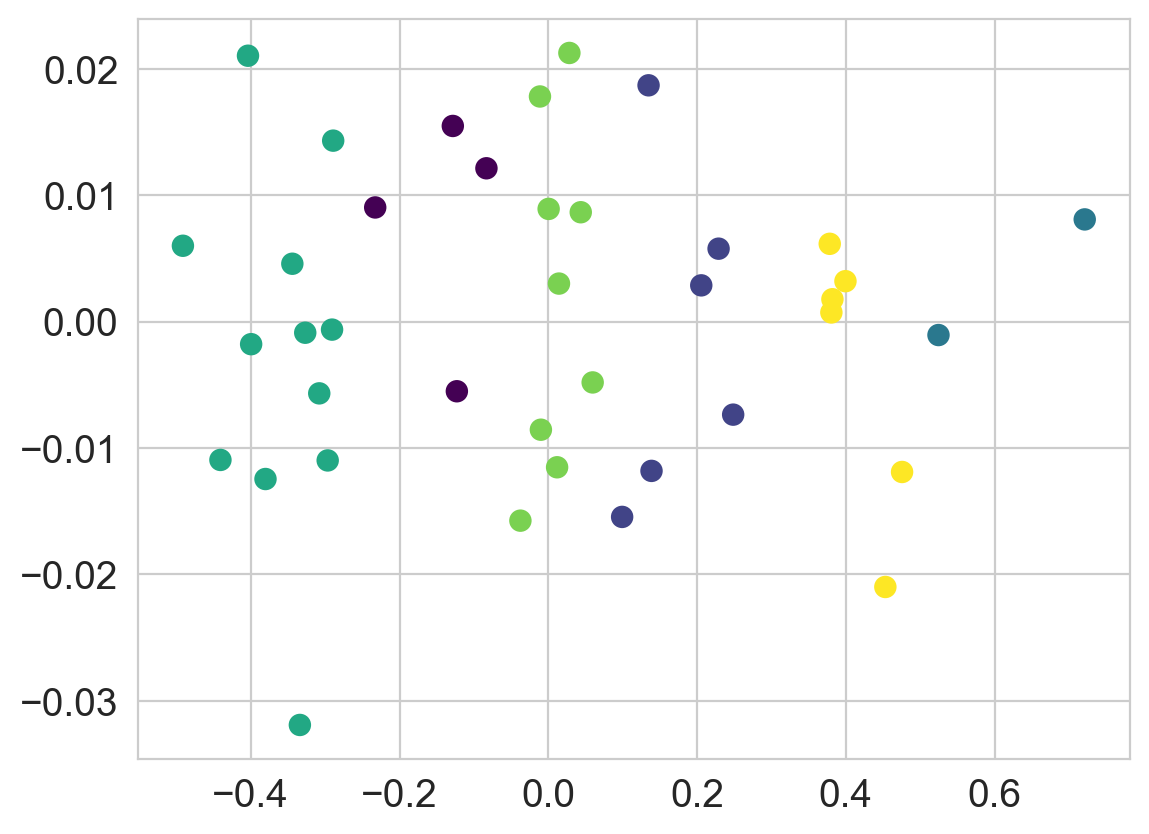

In [86]:
g_kmeans.visualize(display_file_name=True)

Heatmap

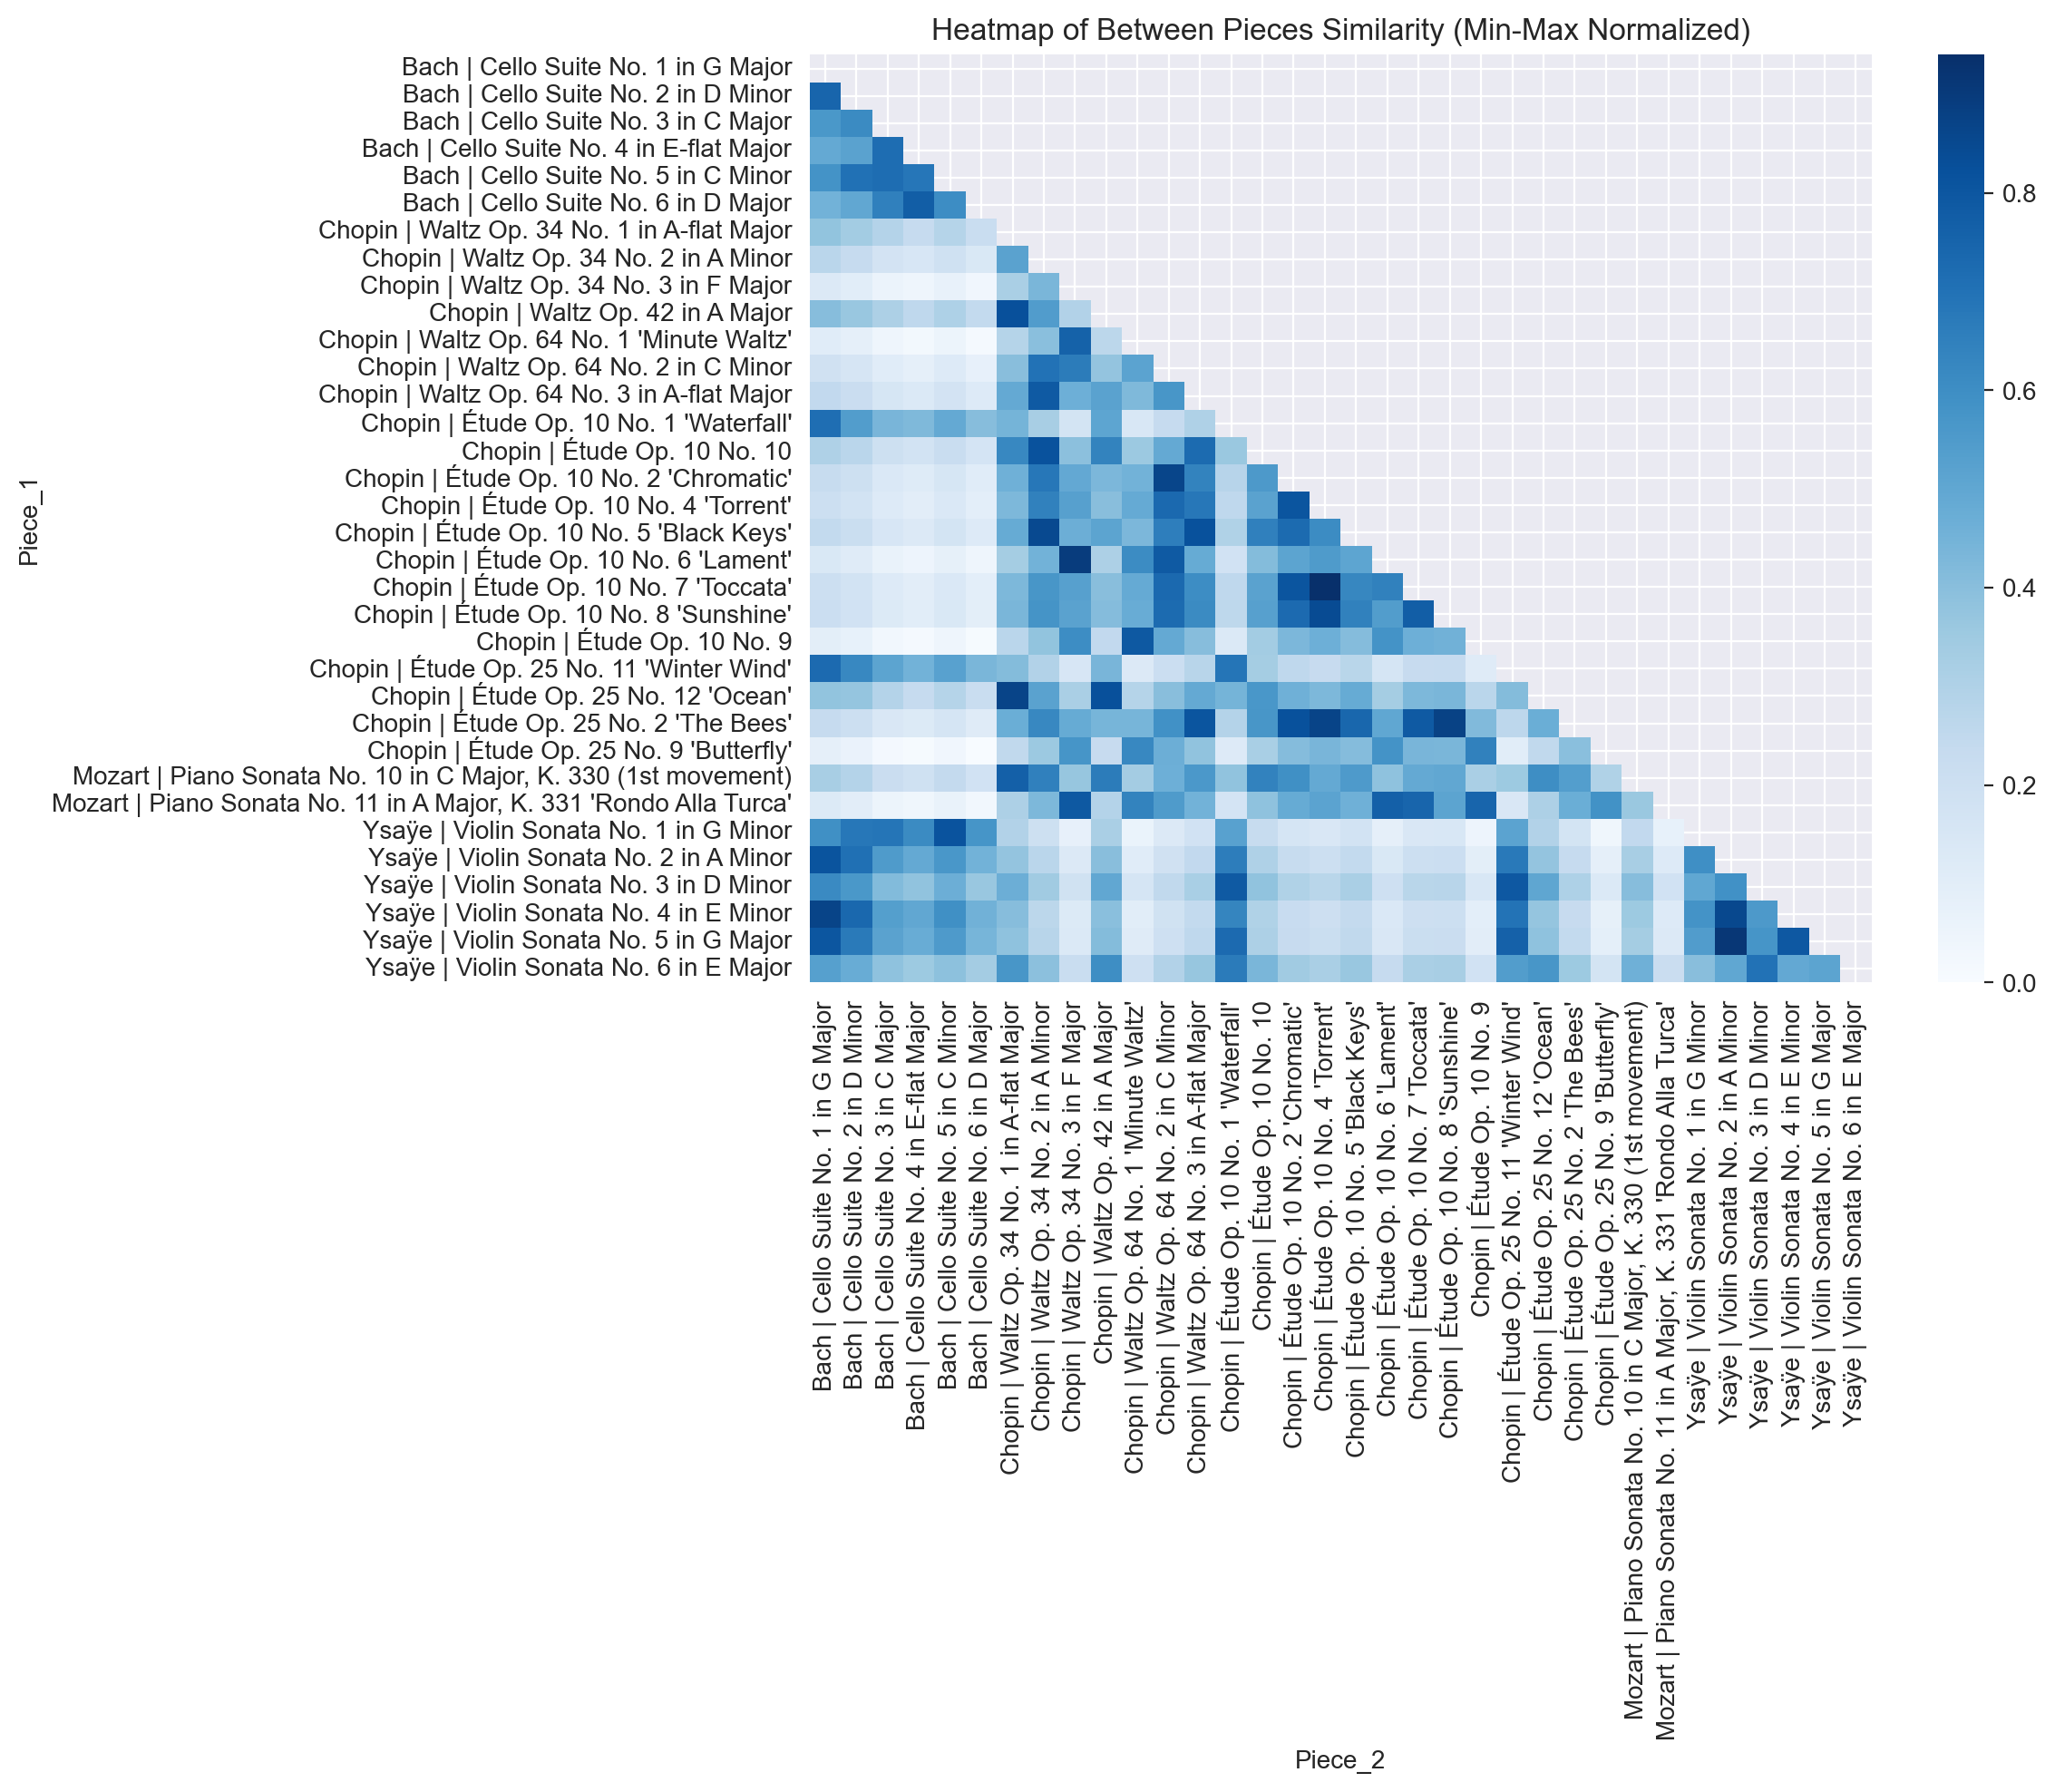

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered is already defined
similarity_matrix_new = df_filtered.pivot_table(index='Piece_1', columns='Piece_2', values='Between_Similarity')

# Create mask for upper triangle (including diagonal if you want to hide it)
mask = np.triu(np.ones_like(similarity_matrix_new, dtype=bool))
# If you want to show the diagonal, uncomment the next line
# np.fill_diagonal(mask, False)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix_new, cmap="Blues", annot=False, cbar=True, fmt=".2f", vmin=0, mask=mask)

# Show the plot
plt.title("Heatmap of Between Pieces Similarity (Min-Max Normalized)")
plt.tight_layout()
plt.show()

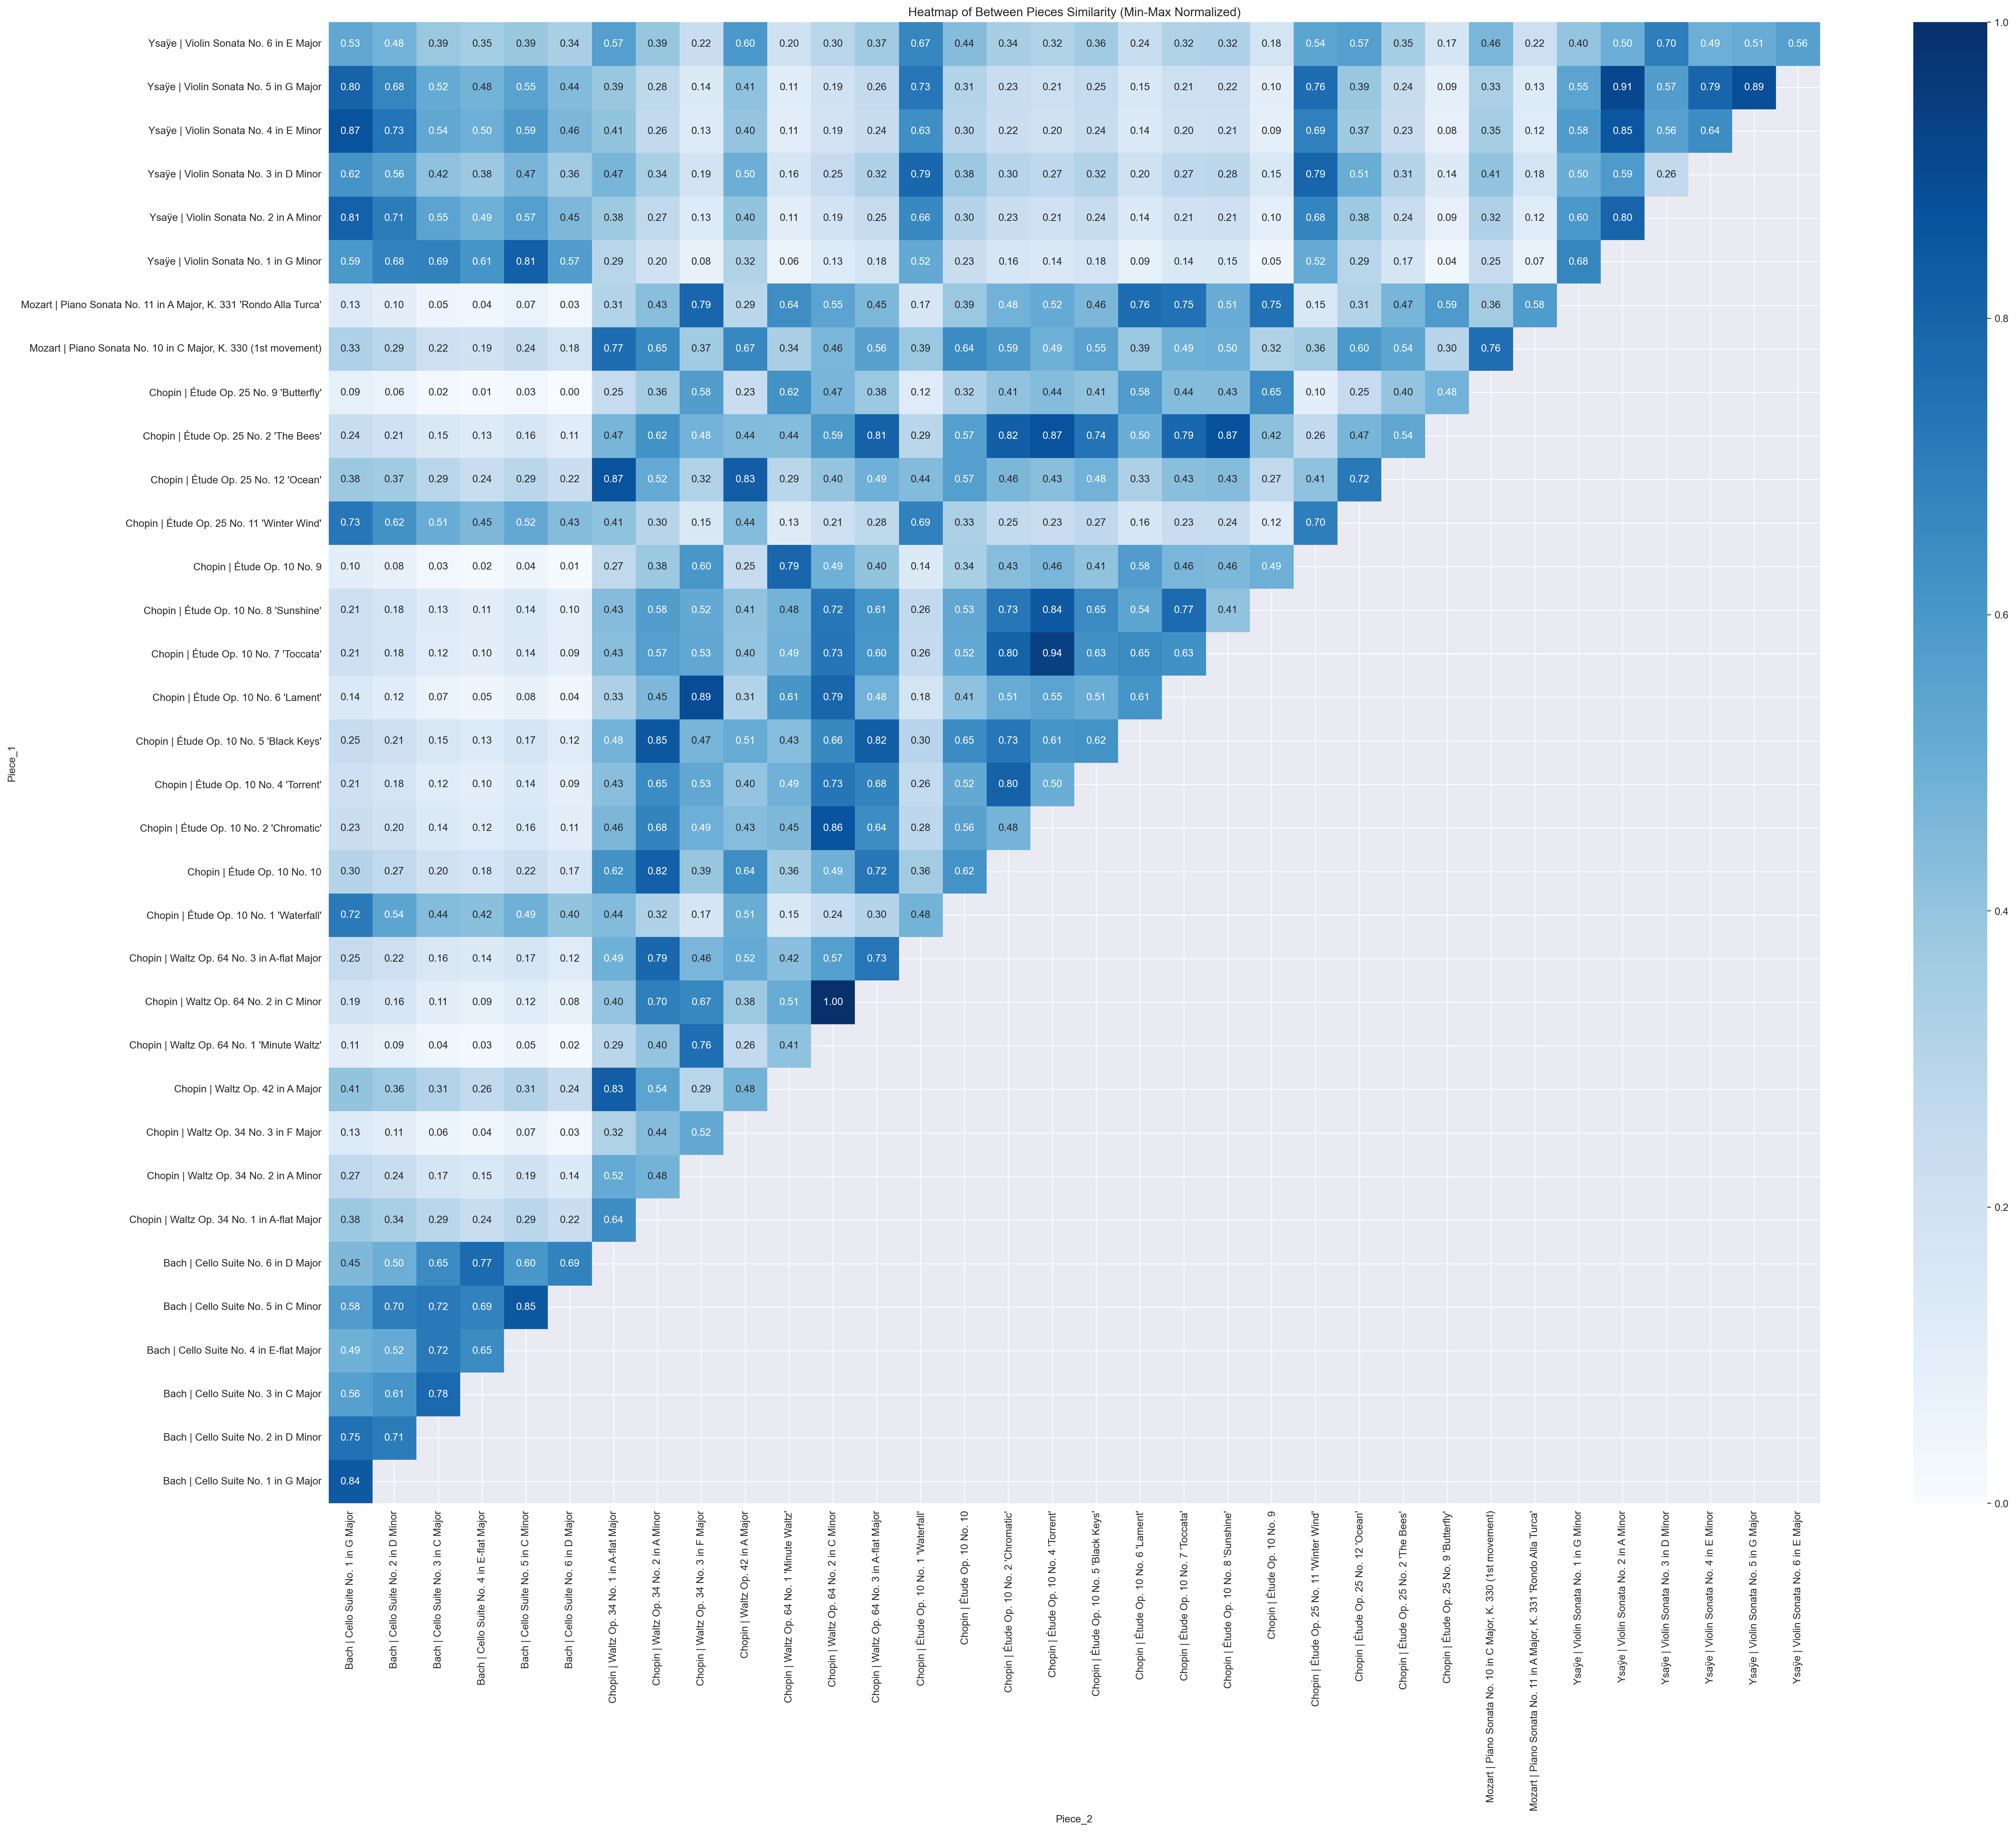

In [46]:
similarity_matrix_new = df_filtered.pivot_table(index='Piece_1', columns='Piece_2', values='Between_Similarity')
similarity_matrix_new = similarity_matrix_new

mask = np.triu(np.ones_like(similarity_matrix_new, dtype=bool))
np.fill_diagonal(mask, False)

# Create a heatmap from the new data
plt.figure(figsize=(30, 25))
sns.heatmap(similarity_matrix_new.iloc[::-1], cmap="Blues", annot=True, cbar=True, fmt=".2f", vmin=0, mask=mask[::-1])

# Show the plot
plt.title("Heatmap of Between Pieces Similarity (Min-Max Normalized)")
plt.tight_layout()
plt.show()

In [47]:
similarity_matrix_new.to_csv("sim_mat.csv", index=True)

<Figure size 1000x800 with 0 Axes>

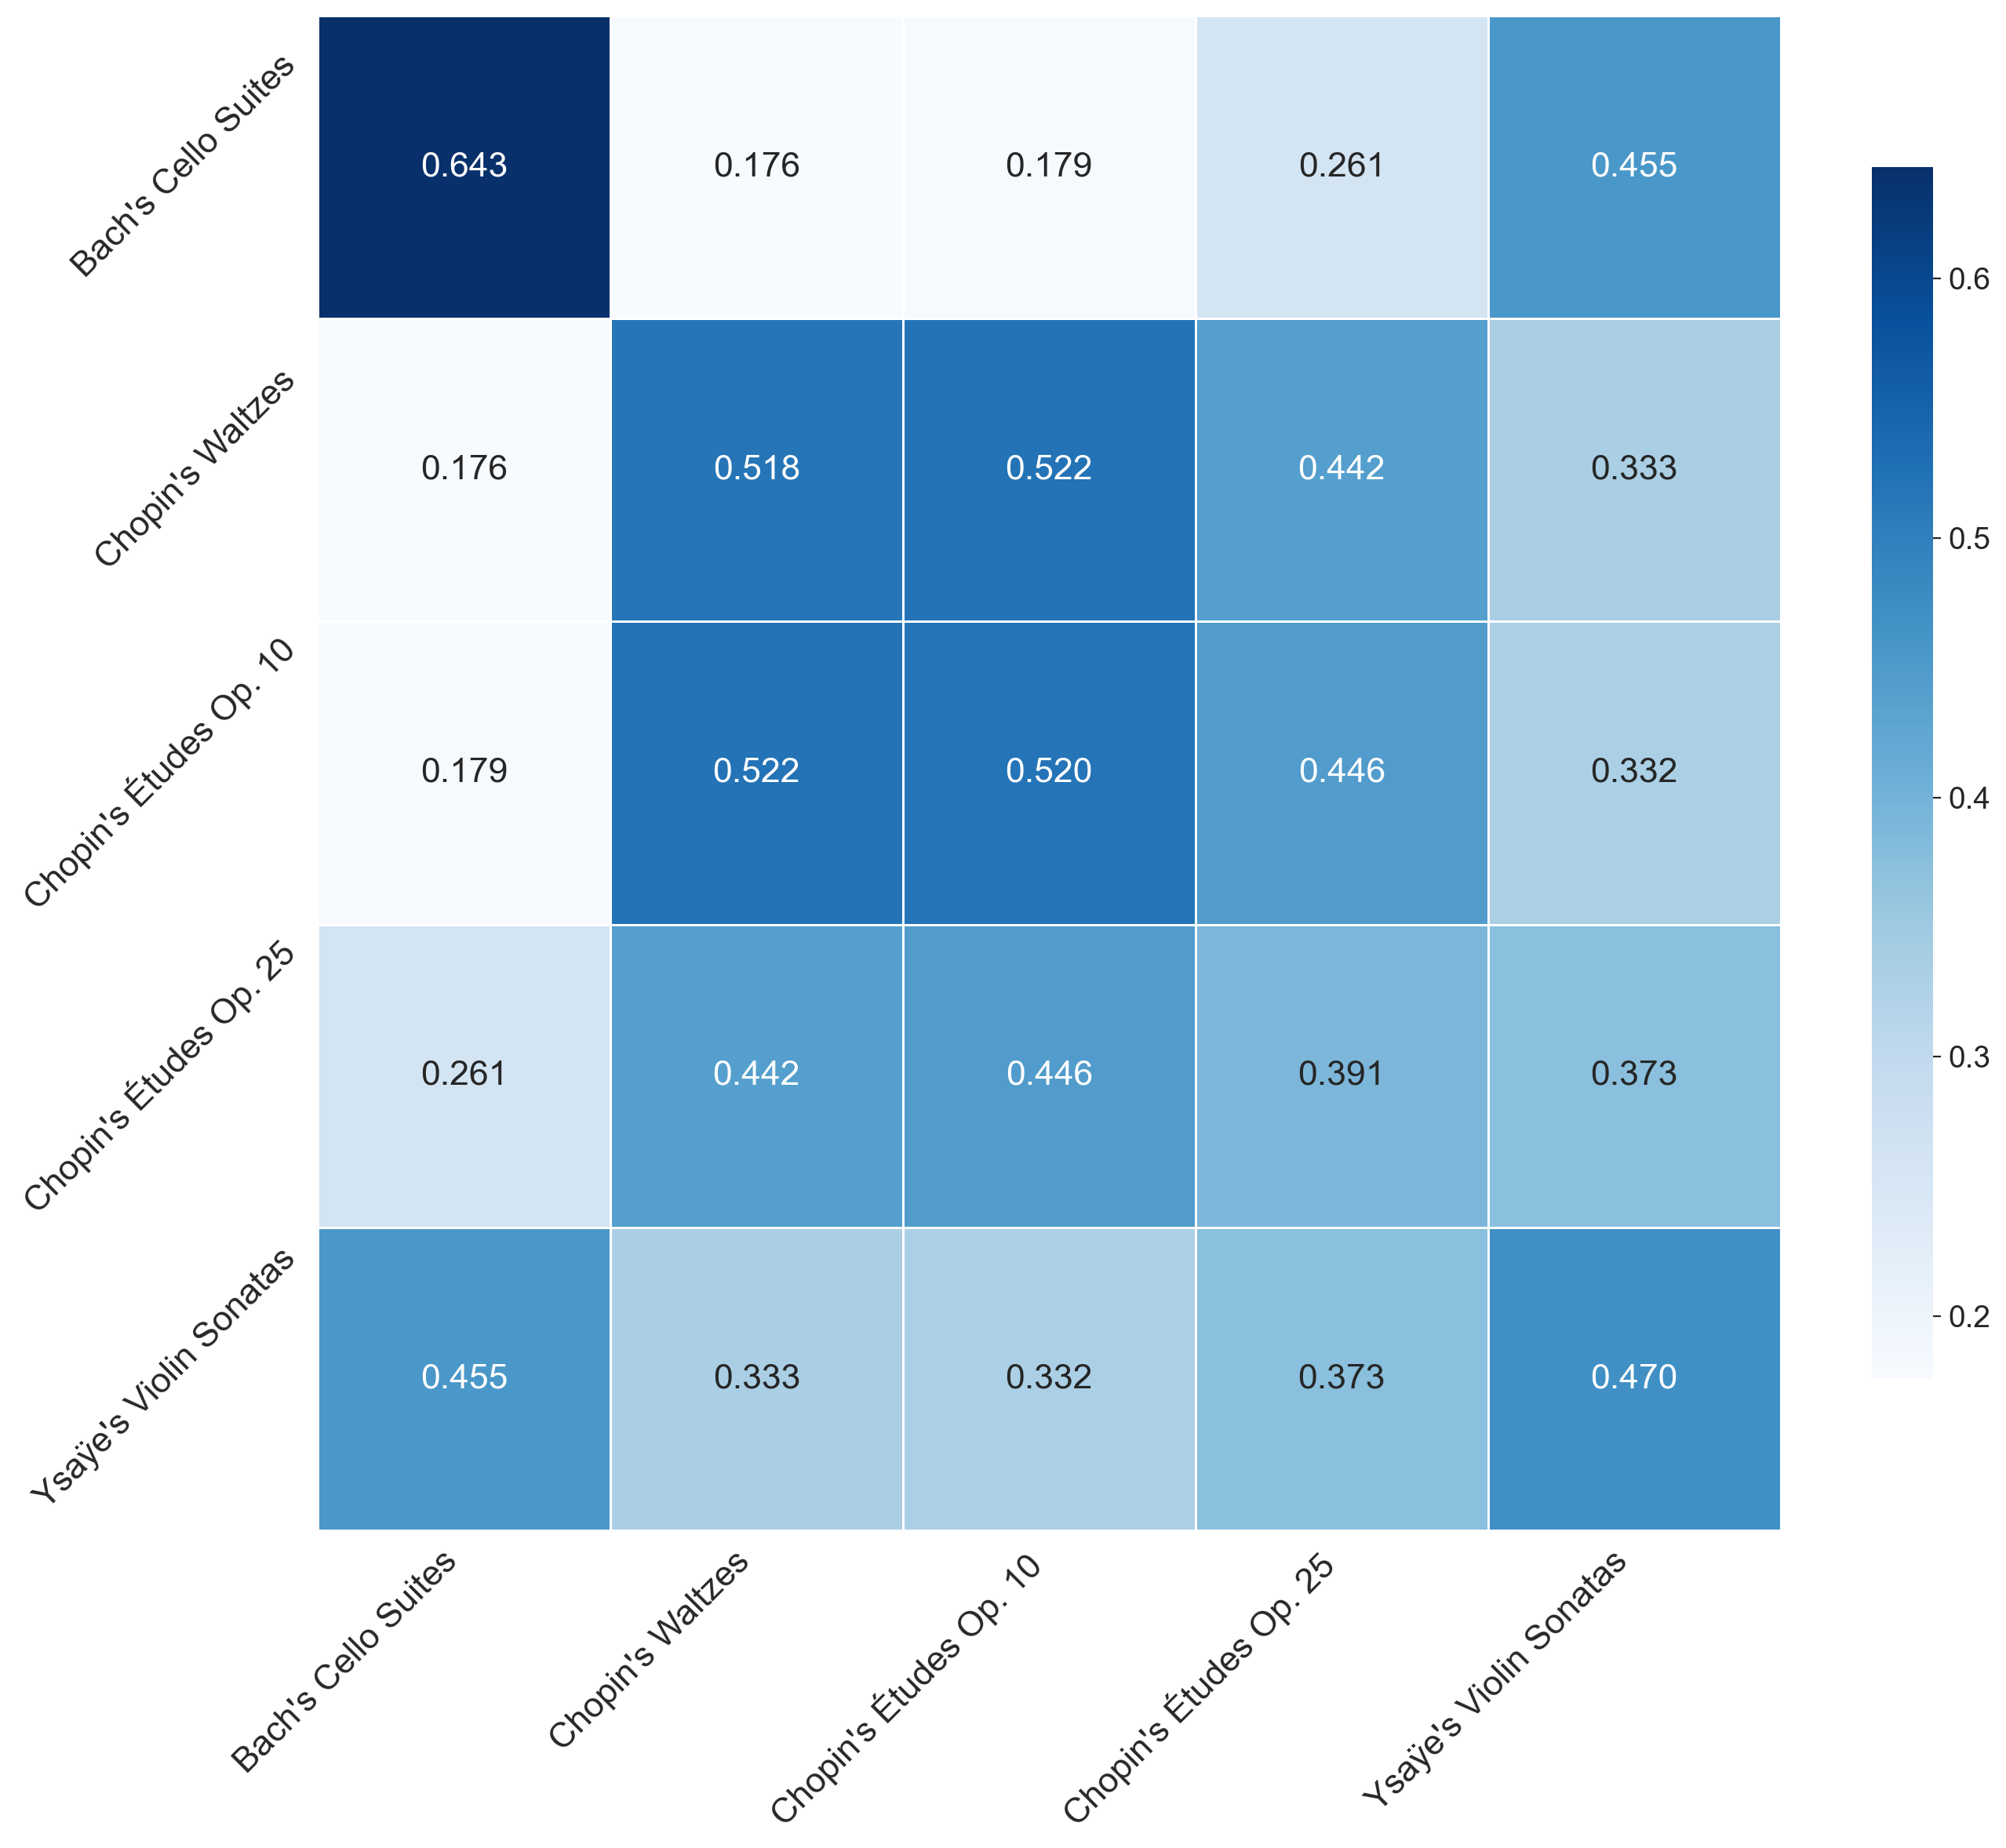

Average Similarity Matrix:
                        Bach's Cello Suites  Chopin's Waltzes  \
Bach's Cello Suites                   0.643             0.176   
Chopin's Waltzes                      0.176             0.518   
Chopin's Études Op. 10                0.179             0.522   
Chopin's Études Op. 25                0.261             0.442   
Ysaÿe's Violin Sonatas                0.455             0.333   

                        Chopin's Études Op. 10  Chopin's Études Op. 25  \
Bach's Cello Suites                      0.179                   0.261   
Chopin's Waltzes                         0.522                   0.442   
Chopin's Études Op. 10                   0.520                   0.446   
Chopin's Études Op. 25                   0.446                   0.391   
Ysaÿe's Violin Sonatas                   0.332                   0.373   

                        Ysaÿe's Violin Sonatas  
Bach's Cello Suites                      0.455  
Chopin's Waltzes                       

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Load the CSV data
df = pd.read_csv('sim_mat.csv')

# Function to determine piece type
def get_piece_type(piece_name):
    parts = piece_name.split('|')
    if len(parts) > 1:
        piece_part = parts[1].strip()

        # Special handling for Chopin's Études
        if 'Étude' in piece_part:
            if 'Op. 10' in piece_part:
                return "Chopin's Études Op. 10"
            elif 'Op. 25' in piece_part:
                return "Chopin's Études Op. 25"
            else:
                return 'Études (General)'
        elif 'Waltz' in piece_part:
            return "Chopin's Waltzes"
        elif 'Sonata' in piece_part:
            return "Ysaÿe's Violin Sonatas"
        elif 'Suite' in piece_part:
            return "Bach's Cello Suites"
        elif 'Ballade' in piece_part:
            return "Chopin's Ballades"
        else:
            # Default to first word
            return piece_part.split(' ')[0]
    return 'Unknown'

# Create a dictionary to map pieces to their types
piece_to_type = {}

# Map column pieces
for col in df.columns[1:]:  # Skip Piece_1 column
    piece_to_type[col] = get_piece_type(col)

# Map row pieces
for piece in df['Piece_1']:
    piece_to_type[piece] = get_piece_type(piece)

# Get unique piece types
piece_types = sorted(set(piece_to_type.values()))

# Create matrices to store sums and counts
similarity_sum = {t1: {t2: 0 for t2 in piece_types} for t1 in piece_types}
similarity_count = {t1: {t2: 0 for t2 in piece_types} for t1 in piece_types}

# Calculate sums and counts
for _, row in df.iterrows():
    row_piece = row['Piece_1']
    row_type = piece_to_type[row_piece]

    for col_piece in df.columns[1:]:
        col_type = piece_to_type[col_piece]
        similarity = row[col_piece]

        if pd.notna(similarity):
            similarity_sum[row_type][col_type] += similarity
            similarity_count[row_type][col_type] += 1

# Calculate averages
avg_similarity = {t1: {t2: (similarity_sum[t1][t2] / similarity_count[t1][t2]
                           if similarity_count[t1][t2] > 0 else 0)
                      for t2 in piece_types}
                 for t1 in piece_types}

# Convert to pandas DataFrame for easier visualization
avg_df = pd.DataFrame(avg_similarity)

# Create the heatmap with larger figure size for better readability
plt.figure(figsize=(14, 12))

# Increase font sizes throughout matplotlib
plt.rcParams.update({'font.size': 14})

ax = sns.heatmap(
    avg_df,
    annot=True,
    cmap="Blues",
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 16}  # Larger annotation font size
)

# Adjust axis labels font size
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=16, rotation=45, ha='right')

# Make colorbar ticks larger
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('piece_type_similarity.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the average similarity matrix for reference
print("Average Similarity Matrix:")
print(avg_df.round(3))

# Find and print some key insights
print("\nKey Insights:")
print(f"Bach's Cello Suites internal similarity: {avg_df.loc['Bach\'s Cello Suites', 'Bach\'s Cello Suites']:.3f}")
print(f"Chopin's Waltzes and Études Op. 10 similarity: {avg_df.loc['Chopin\'s Waltzes', 'Chopin\'s Études Op. 10']:.3f}")
print(f"Bach's Cello Suites and Ysaÿe's Violin Sonatas similarity: {avg_df.loc['Bach\'s Cello Suites', 'Ysaÿe\'s Violin Sonatas']:.3f}")
print(f"Chopin's Études Op. 10 and Op. 25 similarity: {avg_df.loc['Chopin\'s Études Op. 10', 'Chopin\'s Études Op. 25']:.3f}")

<Figure size 1400x1200 with 0 Axes>

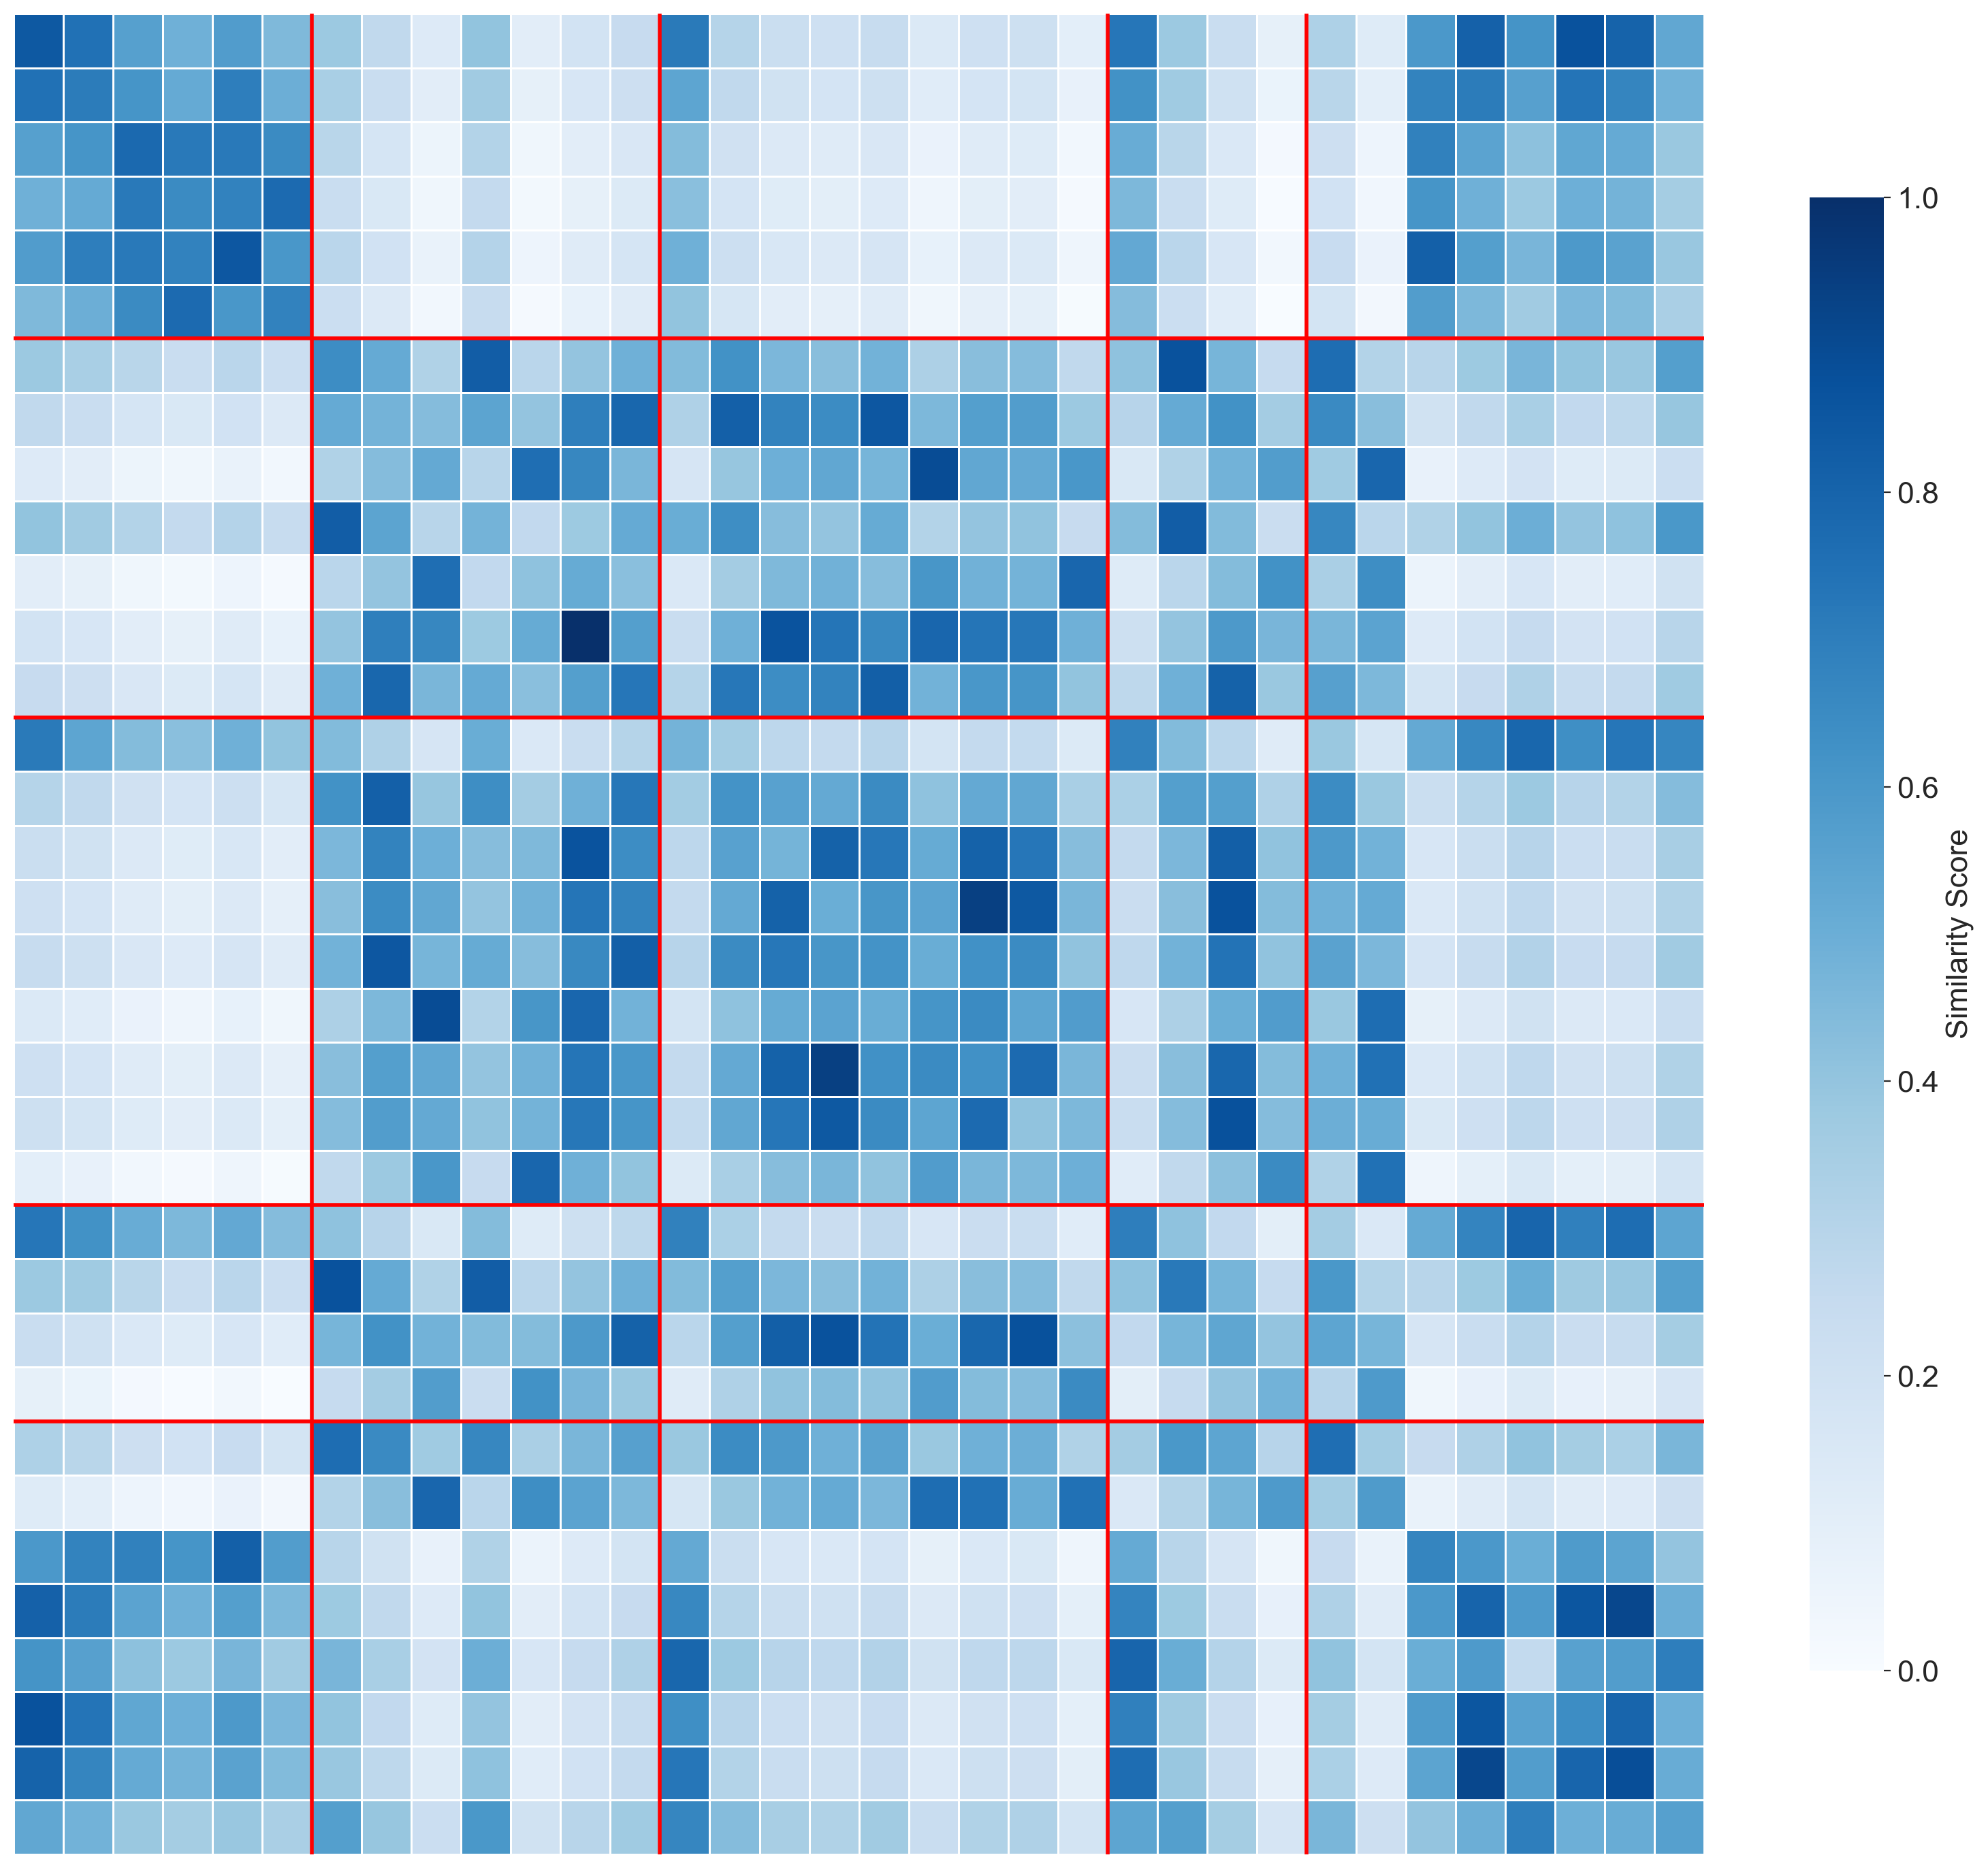

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure aesthetics
plt.figure(figsize=(14, 12))

# Load the CSV data
df = pd.read_csv('sim_mat.csv')

# Convert the data to a square matrix format and remove the index name
similarity_matrix = df.set_index('Piece_1')
similarity_matrix.index.name = None  # Remove the "Piece_1" label

# Group pieces by piece type
def get_piece_type(piece_name):
    parts = piece_name.split('|')
    if len(parts) > 1:
        piece_part = parts[1].strip()

        # Special handling for Chopin's Études
        if 'Étude' in piece_part:
            if 'Op. 10' in piece_part:
                return "Chopin's Études Op. 10"
            elif 'Op. 25' in piece_part:
                return "Chopin's Études Op. 25"
            else:
                return "Études (General)"
        elif 'Waltz' in piece_part:
            return "Chopin's Waltzes"
        elif 'Sonata' in piece_part:
            return "Ysaÿe's Violin Sonatas"
        elif 'Suite' in piece_part:
            return "Bach's Cello Suites"
        elif 'Ballade' in piece_part:
            return "Chopin's Ballades"
        else:
            # Default to first word
            return piece_part.split(' ')[0]
    return 'Unknown'


# Sort the matrix by piece type
piece_types = [get_piece_type(piece) for piece in similarity_matrix.index]
sorted_indices = sorted(range(len(piece_types)), key=lambda i: (piece_types[i], similarity_matrix.index[i]))
sorted_pieces = [similarity_matrix.index[i] for i in sorted_indices]

# Reindex the matrix with the sorted pieces
similarity_matrix = similarity_matrix.reindex(index=sorted_pieces, columns=sorted_pieces)

# Create the heatmap
plt.figure(figsize=(16, 14))
ax = sns.heatmap(
    similarity_matrix,
    cmap="Blues",
    annot=False,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.8,
        "label": "Similarity Score",
    }
)

# Remove title and axis labels
plt.xticks([])
plt.yticks([])
plt.title("")

# Add divider lines between piece types
prev_type = None
for i, piece in enumerate(similarity_matrix.index):
    current_type = get_piece_type(piece)
    if current_type != prev_type and i > 0:
        plt.axhline(y=i, color='red', linewidth=2)
        plt.axvline(x=i, color='red', linewidth=2)
    prev_type = current_type


plt.tight_layout()
plt.savefig('piece_type_similarity_heatmap.png', dpi=300, bbox_inches='tight')